pure python Hypervolume calcuation is really slow. how much faster is the implementation in deap which is cpp?


and how to ensure that the results are the same?

In [2]:
import sys
import os

sys.path.append(os.path.abspath("../.."))
from hypervolume_jk import HypervolumeMetric
from hv_calculation import get_platypus_problem

In [3]:
refset = pd.read_csv("./refsets/squared_exponential_rbf_refset.csv")

In [4]:
refset.shape

(2142, 6)

In [5]:
problem = get_platypus_problem()
hv = HypervolumeMetric(refset, problem)

In [6]:
data = pd.read_csv("../output/squared_exponential_rbf/10_hypervolume.csv")
generations = []
for nfe, generation in data.groupby("Unnamed: 0"):
    generation = generation.rename(
        {
            str(i): name
            for i, name in enumerate(
                [
                    "hydropower",
                    "atomicpowerplant",
                    "baltimore",
                    "chester",
                    "environment",
                    "recreation",
                ]
            )
        },
        axis=1,
    )
    generations.append(generation.iloc[:, 2::])

In [7]:
# let's pick one and see what happens
g = generations[10]
hv.calculate(g)

0.1827265011534952

In [8]:
%%timeit
hv.calculate(g)

118 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


DEAP

In [9]:
from deap.tools import _hypervolume

In [10]:
directions = np.asarray([entry for entry in problem.directions])
directions

array([ 1,  1,  1,  1, -1,  1])




hypervolume in deap assumes minimization towards orgin

so how to scale stuff?


In [11]:
[e for e in problem.directions]

[1, 1, 1, 1, -1, 1]

In [12]:
from sklearn.preprocessing import MinMaxScaler


def handle_directions(data, problem):
    data = data.copy()
    for i in range(data.shape[1]):
        column = data[:, i]
        if problem.directions[i] == problem.MAXIMIZE:
            data[:, i] = 1 - column
    return data


ref_set = refset.values
generation = g.values

# normalize using the min and max across all generations and reference set
# this is slightly different from how platypus handles it
scaler = MinMaxScaler()
# scaler.fit(pd.concat(generations + [refset]).values)
scaler.fit(ref_set)

normalized_refset = scaler.transform(ref_set)
normalized_generation = scaler.transform(generation)

refset_directed = handle_directions(normalized_refset, problem)
generation_directed = handle_directions(normalized_generation, problem)


maxima = np.max(refset_directed, axis=0)
minima = np.min(refset_directed, axis=0)

print(minima)
print(maxima)
print(_hypervolume.hv.hypervolume(generation_directed, maxima))
print(_hypervolume.hv.hypervolume(normalized_generation, maxima))
# print(_hypervolume.hv.hypervolume(normalized_refset, maxima))

[0.00000000e+00 1.11022302e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1. 1. 1. 1. 1. 1.]
0.18272917912591055
0.0921358953110628


In [21]:
from sklearn.preprocessing import MinMaxScaler


def handle_directions(data, problem):
    data = data.copy()
    for i in range(data.shape[1]):
        column = data[:, i]
        if problem.directions[i] == problem.MAXIMIZE:
            data[:, i] = 1 - column
    return data


def transform_data(data, scaler, problem):
    data = data.copy()
    # setup a scaler

    # scale data
    transformed_data = scaler.transform(data)

    # handle directions
    transformed_data = handle_directions(transformed_data, problem)

    return transformed_data


problem = get_platypus_problem()
ref_set = refset.values
generation = generations[10].values

scaler = MinMaxScaler()
scaler.fit(pd.concat(generations + [refset]).values)
# scaler.fit(refset.values)

refset_directed = transform_data(ref_set, scaler, problem)
generation_directed = transform_data(generation, scaler, problem)

maxima = np.max(refset_directed, axis=0)

print(_hypervolume.hv.hypervolume(generation_directed, maxima))
# print(_hypervolume.hv.hypervolume(refset_directed, maxima))

0.05131871845627441


In [22]:
from hv_calculation import load_archives

archives, list_of_archives = load_archives()

In [27]:
scaler = MinMaxScaler()
scaler.fit(pd.concat(list_of_archives + [refset]).values)
reference_set = transform_data(refset.values, scaler, problem)
maxima = np.max(reference_set, axis=0)
maxima

array([0.64160023, 0.95393949, 0.98885804, 0.95541082, 0.25767288,
       0.25      ])

In [29]:
hv = _hypervolume.hv.hypervolume(reference_set, maxima)
hv

0.021748947298684047

In [31]:
dict(hv=hv)

{'hv': 0.021748947298684047}

In [32]:
pd.Series(dict(hv=hv)).to_csv("./calculated_metrics/hv_refset_global.csv")

In [130]:
problem = get_platypus_problem()

scaler = MinMaxScaler()
scaler.fit(pd.concat(generations + [refset]).values)


refset_directed = transform_data(refset.values, scaler, problem)
maxima = np.max(refset_directed, axis=0)


hypervolume = []
for generation in generations[0:200]:
    generation_directed = transform_data(generation.values, scaler, problem)
    hv = _hypervolume.hv.hypervolume(generation_directed, maxima)
    hypervolume.append(hv)

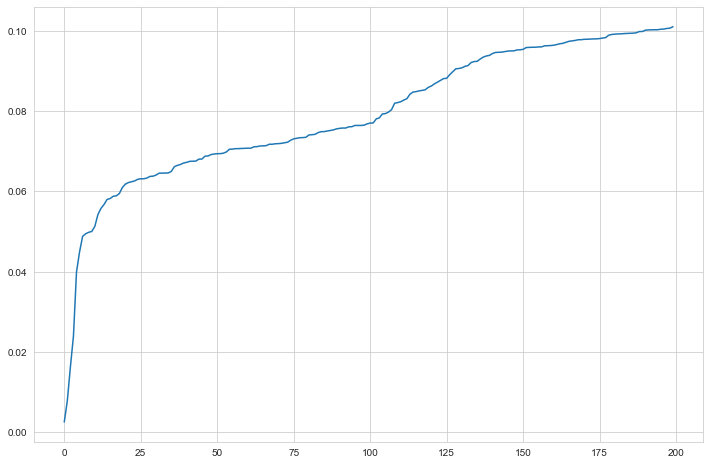

In [131]:
fig, ax = plt.subplots()
ax.plot(hypervolume)

In [134]:
generations[-1].shape

(1333, 6)

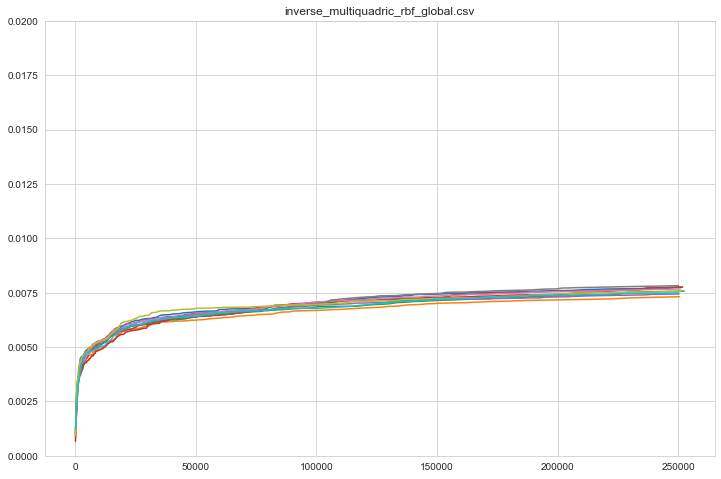

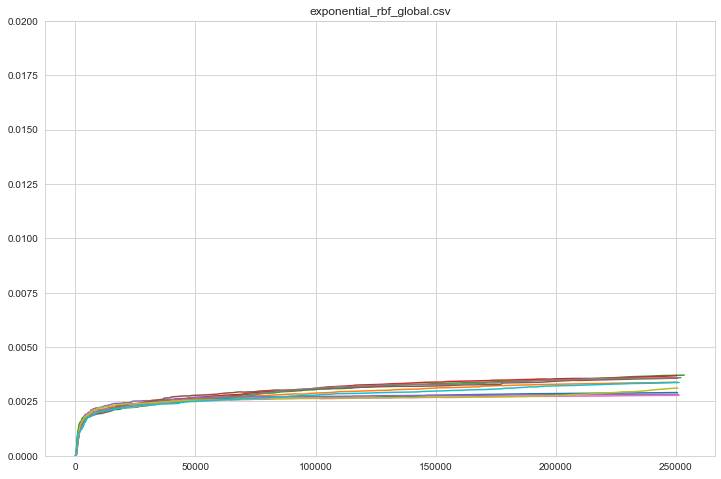

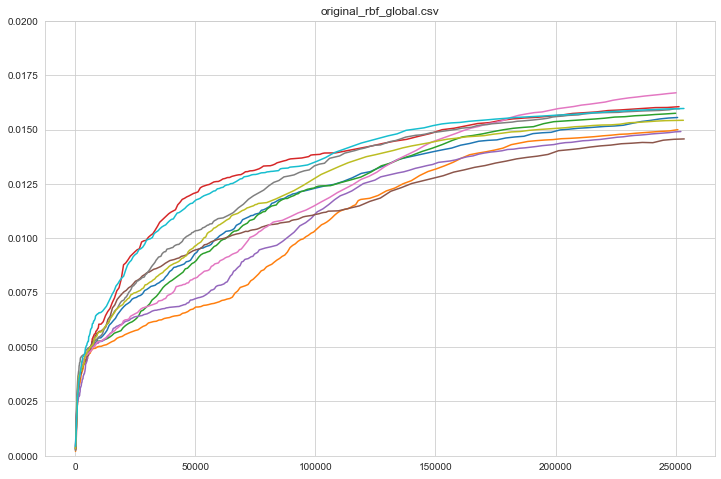

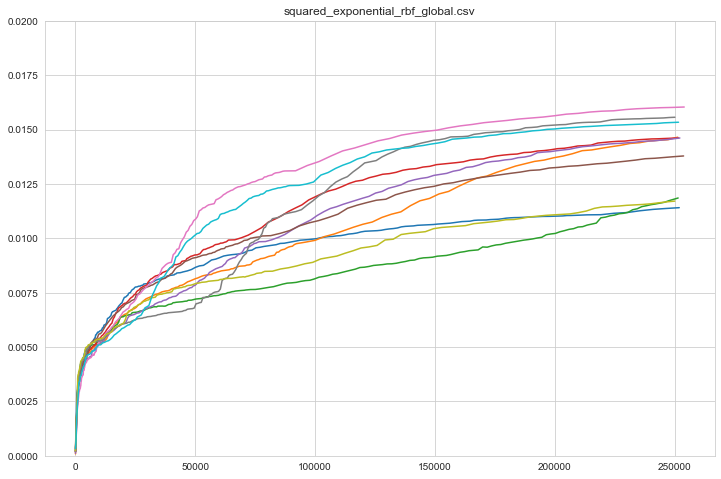

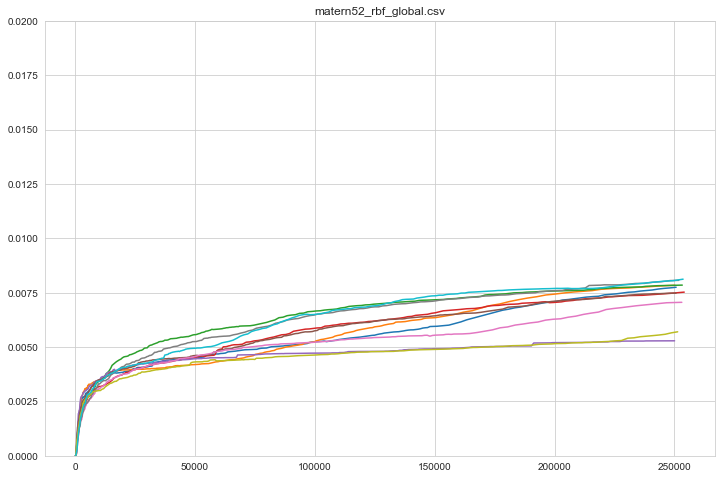

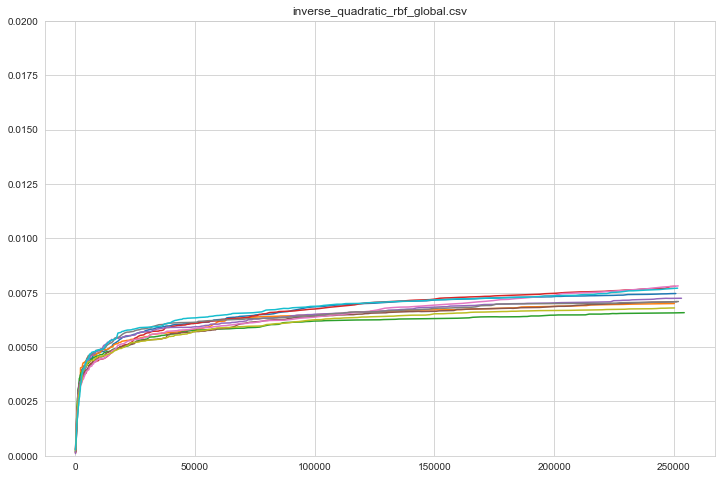

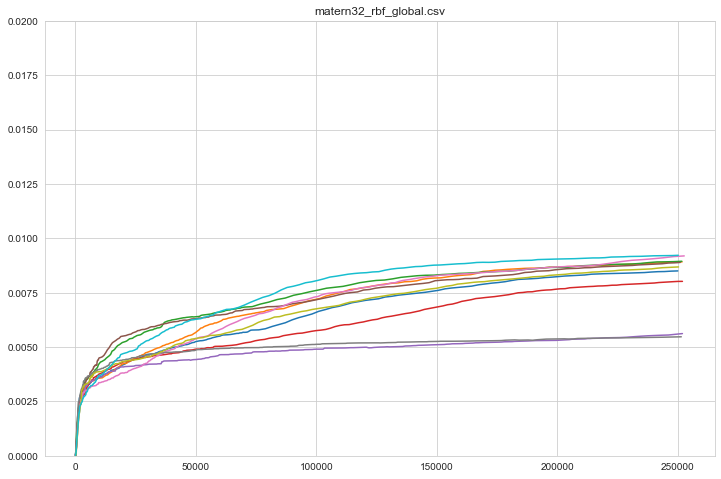

In [32]:
import os

for entry in os.listdir("./calculated_metrics/"):
    data = pd.read_csv(os.path.join("./calculated_metrics", entry))
    fig, ax = plt.subplots()
    ax.set_title(entry)
    ax.set_ylim(ymax=0.02)

    for seed, entry in data.groupby("seed"):
        ax.plot(entry.nfe, entry.hypervolume)